In [91]:
import shap
import pandas as pd
import scipy as sp
import numpy as np
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, mean_squared_error
import matplotlib.pyplot as plt
from treeinterpreter.feature_importance import feature_importance as FI
from treeinterpreter.feature_importance import MDA

# Regression: Compare different methods in terms of feature selection using simulated data 

### load data

In [92]:
X_train = np.loadtxt('../intermediate/02_enhancer/X_train.csv', delimiter=',')
y_train = np.loadtxt('../intermediate/02_enhancer/y_train.csv', delimiter=',')
X_test = np.loadtxt('../intermediate/02_enhancer/X_test.csv', delimiter=',')
y_test = np.loadtxt('../intermediate/02_enhancer/y_test.csv', delimiter=',')
n, m = X_train.shape
names = np.arange(m)

In [93]:
def permute(X, noisy_features):
    tmp = X.copy()
    for j in range(X.shape[1]):
        if noisy_features[j] == 1:
            tmp[:, j] = np.random.permutation(tmp[:, j])
    return tmp
def f(X, noisy_features):
    y = np.mean(X[:, noisy_features == 0], 1) 
    y += np.random.normal(0, np.std(y) ** 2 * 100, y.shape)
    return y

In [94]:
n_features = X_train.shape[1]
n, m = X_train.shape
names = np.arange(m)
scaler = MinMaxScaler()
noisy_features = np.ones((n_features, ), dtype=int)
noisy_features[np.random.choice(range(n_features), 5, replace=False)] = 0
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = permute(X_train, noisy_features)
X_test = permute(X_test, noisy_features)
y_train = f(X_train, noisy_features)
y_test = f(X_test, noisy_features)

### save intermediate

In [95]:
np.savetxt('../intermediate/02_enhancer_regression/permuted1_X_train.csv', X_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer_regression/permuted1_y_train.csv', y_train, delimiter=',')
np.savetxt('../intermediate/02_enhancer_regression/permuted1_X_test.csv', X_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer_regression/permuted1_y_test.csv', y_test, delimiter=',')
np.savetxt('../intermediate/02_enhancer_regression/permuted1_noisy_features.csv', noisy_features, delimiter=',')

### Train RF

In [96]:
rf = rfr(n_estimators=100, max_features=8)
rf.fit(X_train, y_train)
gini_imp = rf.feature_importances_

- accuracy

In [97]:
print('MSE of RF is {0:.3f}'.format(mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test))))

MSE of RF is 0.317


- Plot feature importance

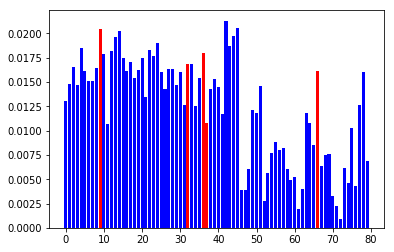

In [98]:
noisy_features = np.array([int(x) for x in noisy_features])
colors = np.array(['red', 'blue'])[noisy_features]
plt.bar(x = np.arange(X_train.shape[1]), height = gini_imp, color = colors)
plt.show()

### prune features based on their importance measures

- classic gini importance

     - plot the gini importance

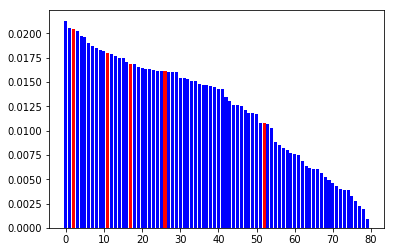

In [99]:
ix = np.argsort(gini_imp * -1)
plt.bar(x = list(range(m)), height = gini_imp[ix], color = colors[ix])
#plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- debiased gini importance

In [126]:
%timeit debiased_fi_mean, debiased_fi_std = FI(rf, X_train, y_train[:, np.newaxis], type='oob', normalized=False)

17.3 s ± 92.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

    - plot debiased gini importance

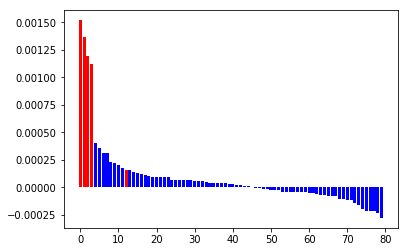

In [101]:
debiased_imp = debiased_fi_mean
ix = np.argsort(debiased_imp * -1)
plt.bar(x = list(range(m)), height = debiased_imp[ix], color=colors[ix])
#plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- MDA

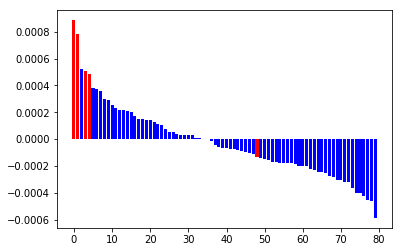

In [102]:
MDA_imp, _ = MDA(rf, X_test, y_test[:, np.newaxis], type='test', n_trials=10, metric='mse')
#MDA_imp[MDA_imp < 0] = 0
ix = np.argsort(MDA_imp * -1)
plt.bar(x = list(range(m)), height = MDA_imp[ix], color=colors[ix])
#plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

- tree SHAP

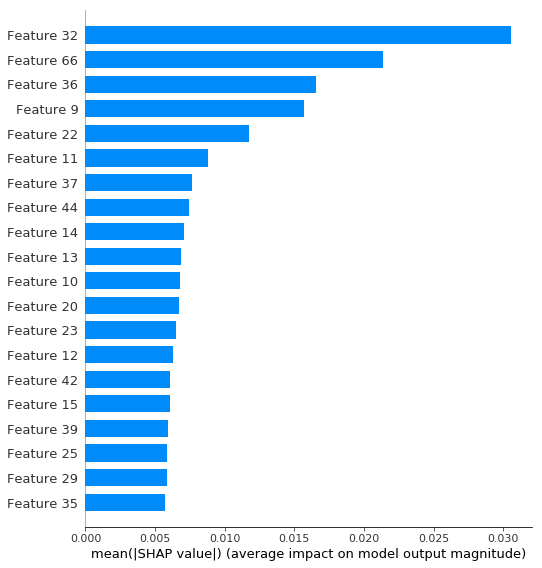

In [103]:
explainer = shap.TreeExplainer(rf)
samples = np.random.choice(range(X_train.shape[0]), 100)
shap_values = explainer.shap_values(X_train[samples, :])
shap.summary_plot(shap_values, X_train[samples, :], plot_type="bar")

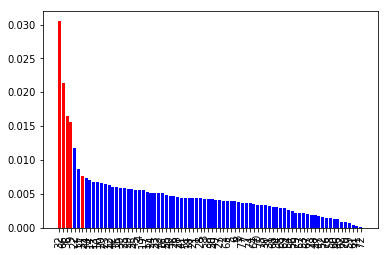

In [104]:
shap_imp = np.mean(abs(shap_values), 0)
ix = np.argsort(shap_imp * -1)
plt.bar(x = list(range(m)), height = shap_imp[ix], color=colors[ix])
plt.xticks(list(range(m)), np.array(names)[ix], rotation='vertical')
plt.show()

### Comparison

In [105]:
debiased_imp[debiased_imp < 0] = 0
MDA_imp[MDA_imp < 0] = 0

In [106]:
roc_auc_score(noisy_features, - debiased_imp)

0.9786666666666667

In [107]:
roc_auc_score(noisy_features, - gini_imp)

0.7386666666666667

In [108]:
roc_auc_score(noisy_features, - shap_imp)

0.9946666666666667

In [109]:
roc_auc_score(noisy_features, - MDA_imp)

0.8533333333333334

<hr />

### summary of the results from .py file

In [122]:
tmp = np.load('../intermediate/02_simulation_results_correlated_features_max_feature_8.npz')
debiased, gini, shap, mda = [tmp[x] for x in list(tmp)]

In [123]:
tmp2 = pd.read_csv('../intermediate/02_simulation_results_R_correlated.csv')
gini_R, ranger, cforest = np.array(tmp2.iloc[:, 1]), np.array(tmp2.iloc[:, 2]), np.array(tmp2.iloc[:, 3])
gini_R, ranger, cforest

(array([0.524     , 0.80533333, 0.512     , 0.54533333, 0.61333333,
        0.824     , 0.80933333, 0.73866667, 0.79466667, 0.80666667,
        0.45866667, 0.99733333, 0.696     , 0.65866667, 0.64133333,
        0.64666667, 0.62133333, 0.63733333, 0.828     , 0.81866667,
        0.99466667, 0.624     , 0.58133333, 0.48666667, 0.73866667,
        0.596     , 0.81066667, 0.52533333, 0.66      , 0.84533333,
        0.81066667, 0.52      , 0.576     , 0.648     , 0.616     ,
        0.59733333, 0.96266667, 0.80666667, 0.54933333, 0.556     ]),
 array([0.48533333, 0.86133333, 0.69866667, 0.424     , 0.68533333,
        0.928     , 0.85866667, 0.54933333, 0.71866667, 0.792     ,
        0.664     , 0.88266667, 0.77333333, 0.66933333, 0.664     ,
        0.78266667, 0.824     , 0.62133333, 0.88933333, 0.68533333,
        0.984     , 0.816     , 0.65066667, 0.59066667, 0.82666667,
        0.49866667, 0.91066667, 0.736     , 0.79733333, 0.872     ,
        0.81866667, 0.64533333, 0.38933333, 0.

In [124]:
out = np.array([debiased, shap,ranger, mda, cforest, gini]).T

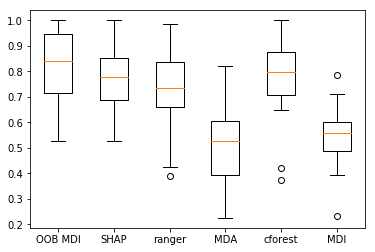

In [125]:
plt.boxplot(out)
plt.xticks(list(range(1, 7)), ['OOB MDI', 'SHAP', 'ranger', 'MDA', 'cforest', 'MDI'])
plt.show()

In [121]:
np.mean(out, 0)

array([0.75066667, 0.66103333, 0.7299    , 0.5239    , 0.78196667,
       0.62723333])